In [1]:
from io import StringIO
import os
import requests
import pandas as pd

## How to setup this notebook

1. Register with PVOutput.org
    * As well as an API key, you *need* a SystemId to use the API.  (If you don't include a SystemId, then you'll get a "401 Unauthorized" response from the PVOutput.org API).  If you don't have a PV system, click the "energy consumption only" box when setting a system id on PVOutput.org.
    * Set the environment variables PVOUTPUT_APIKEY and PVOUTPUT_SYSTEMID (on Linux, put `EXPORT PVOUTPUT_APIKEY="API KEY"` etc. into `.profile`, log out, and log back in again)




## Good systems
Good system: https://pvoutput.org/intraday.jsp?id=68872&sid=61190

## API docs
The following HTTP Headers need to be set to authenticate the service request.

* X-Pvoutput-Apikey
* X-Pvoutput-SystemId

### Useful sections in API docs
* [API Search](https://pvoutput.org/help.html#api-search)
* [Get Status](https://pvoutput.org/help.html#api-getstatus) - used for getting live and historical PV power output (and other data)




In [100]:
SECONDS_PER_DAY = 60 * 60 * 24

class BadStatusCode(Exception):
    pass


def pv_output_api_query(service, api_params):
    """
    Args:
        service: string, e.g. 'search', 'getstatus'
    """
    
    headers = {
        'X-Pvoutput-Apikey': os.environ['PVOUTPUT_APIKEY'],
        'X-Pvoutput-SystemId': os.environ['PVOUTPUT_SYSTEMID']}
    
    api_base_url = 'https://pvoutput.org/service/r2/{}.jsp'.format(service)
    api_params_str = '&'.join(['{}={}'.format(key, value) for key, value in api_params.items()])
    api_url = '{}?{}'.format(api_base_url, api_params_str)
    response = requests.get(api_url, headers=headers)
    
    try:
        content = response.content.decode('latin1').strip()
    except UnicodeDecodeError as e:
        print("Error decoding this string: {}\n{}".format(content, e))
        raise
    
    if response.status_code == 200:
        return content
    else:
        raise BadStatusCode('Bad status code returned: {}, {}'.format(response.status_code, content))

## Search for PV systems

In [3]:
def pv_system_search(query, lat_lon):
    """
    Args:
        query: string, see https://pvoutput.org/help.html#search
            e.g. '5km'.  Max search radius = 25km
        lat_lon: string, e.g. '52.0668589,-1.3484038'
        
    Returns:
        pd.DataFrame.  Beware the maximum number of results returned by PVOutput.org is 30.
    """
    
    pv_systems_text = pv_output_api_query(
        service='search',
        api_params={
            'q': query,
            'll': lat_lon,
            'country': 1  # country flag, whether or not to return country with the postcode
        })
    
    pv_systems = pd.read_csv(
        StringIO(pv_systems_text),
        names=[
            'system_name',
            'system_size_watts',
            'postcode',
            'orientation',
            'num_outputs',
            'last_output',
            'system_id',
            'panel',
            'inverter',
            'distance_km',
            'latitude',
            'longitude'],
        index_col='system_id')

    return pv_systems

In [4]:
pv_systems = pv_system_search(query='5km', lat_lon='52.0668589,-1.3484038')

In [5]:
good_pv_systems = pv_systems.query('num_outputs > 50')
good_pv_systems

,system_name,system_size_watts,postcode,orientation,num_outputs,last_output,panel,inverter,distance_km,latitude,longitude
system_id,,,,,,,,,,,
61190,Banbury OX16,5600,United Kingdom OX16,S,333,Today,SunPower,SolarEdge 5K HD,1.0,52.06,-1.34
62751,Banbury PW2,5600,United Kingdom OX16,S,83,25 weeks ago,Sunpower,Energy Monitor,1.0,52.06,-1.34
38924,CotonMacy Solar,3900,United Kingdom OX16,S,1462,Today,LG LG300 N1C-B3 LG,Enphase m250,1.0,52.06,-1.34
23236,Tedsolar,3000,United Kingdom OX16,SE,691,205 weeks ago,Renesolar,Samil SR3300tl,1.0,52.06,-1.34
40100,100061786,3900,United Kingdom OX17,S,62,183 weeks ago,Caymax SSE195,Enecsys SMI-S240W,4.7,52.07,-1.28
36566,CartwrightRoad,3900,United Kingdom OX17,S,3013,Today,Caymax SSE195,Enecsys SMI-S240W,4.7,52.07,-1.28


## Get system status (power generation)

In [114]:
def get_pv_system_status(pv_system_id, date):
    """
    Args:
        pv_system_id: int
        date: str, YYYYMMDD
    """
    pv_system_status_text = pv_output_api_query(
        service='getstatus',
        api_params={
            'd': date, # date, YYYYMMDD
            'h': 1,  # History; we want historical data
            'limit': SECONDS_PER_DAY,  # API docs say limit is 288 (number of 5-min periods per day),
                                       # but let's try to get number of secs per day just in case 
                                       # some PV systems have 1-second updates.
            'ext': 0, # extended data; we don't want extended data because it's not clear how to parse it.
            'sid1': pv_system_id # SystemID
        })
    
    pv_system_status = pd.read_csv(
        StringIO(pv_system_status_text),
        lineterminator=';',
        names=[
            'date',
            'time',
            'energy_generation_watt_hours',
            'energy_efficiency_kWh_per_kW',
            'inst_power_watt',
            'average_power_watt',
            'normalised_output',
            'energy_consumption_watt_hours',
            'power_consumption_watts',
            'temperature_celsius',
            'voltage'
        ],
        parse_dates={'datetime': ['date', 'time']},
        index_col=['datetime']
    )
    
    return pv_system_status

In [120]:
pv_system_id = 38924
pv_system_status = get_pv_system_status(pv_system_id, date='20190715')
pv_system_status.describe()

,energy_generation_watt_hours,energy_efficiency_kWh_per_kW,inst_power_watt,average_power_watt,normalised_output,energy_consumption_watt_hours,power_consumption_watts,temperature_celsius,voltage
count,196.000000,196.000000,196.000000,195.000000,195.000000,0.0,0.0,0.0,0.0
mean,6320.622449,1.620684,900.882653,905.476923,0.232195,NaN,NaN,NaN,NaN
std,5550.282705,1.423158,709.945756,709.131568,0.181844,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,847.000000,0.217250,229.250000,240.000000,0.062000,NaN,NaN,NaN,NaN
50%,4860.500000,1.246500,852.000000,864.000000,0.222000,NaN,NaN,NaN,NaN
75%,12096.500000,3.101750,1373.500000,1374.000000,0.352500,NaN,NaN,NaN,NaN
max,14714.000000,3.773000,2662.000000,2664.000000,0.683000,NaN,NaN,NaN,NaN


In [121]:
pv_system_status.head()

,energy_generation_watt_hours,energy_efficiency_kWh_per_kW,inst_power_watt,average_power_watt,normalised_output,energy_consumption_watt_hours,power_consumption_watts,temperature_celsius,voltage
datetime,,,,,,,,,
2019-07-15 21:20:00,14714,3.773,0,0.0,0.000,NaN,NaN,NaN,NaN
2019-07-15 21:15:00,14714,3.773,0,0.0,0.000,NaN,NaN,NaN,NaN
2019-07-15 21:10:00,14714,3.773,4,0.0,0.000,NaN,NaN,NaN,NaN
2019-07-15 21:05:00,14714,3.773,12,12.0,0.003,NaN,NaN,NaN,NaN
2019-07-15 21:00:00,14713,3.773,12,12.0,0.003,NaN,NaN,NaN,NaN


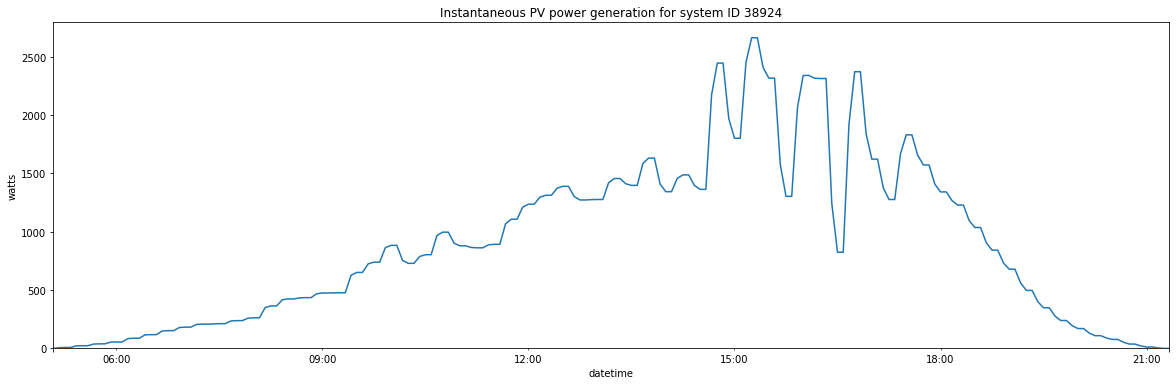

In [132]:
ax = pv_system_status['inst_power_watt'].plot(figsize=(20, 6))
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_ylabel('watts')
ax.set_title('Instantaneous PV power generation for system ID {}'.format(pv_system_id));

## Get system metadata

In [186]:
def get_pv_metadata(pv_system_id):
    """
    Args:
        pv_system_id: int
    """
    pv_metadata_text = pv_output_api_query(
        service='getsystem',
        api_params={
            'array2': 1,  # provide data about secondary array, if present
            'tariffs': 0,
            'teams': 0,
            'est': 0,
            'donations': 0,
            'sid1': pv_system_id, # SystemID
            'ext': 0, # extended data
        })
    
    pv_metadata = pd.read_csv(
        StringIO(pv_metadata_text),
        lineterminator=';',
        names=[
            'system_name',
            'system_size_watts',
            'postcode',
            'number_of_panels',
            'panel_power_watts',
            'panel_brand',
            'num_inverters',
            'inverter_power_watts',
            'inverter_brand',
            'orientation',
            'array_tilt_degrees',
            'shade',
            'install_date',
            'latitude',
            'longitude',
            'status_interval_minutes',
            'number_of_panels_secondary',
            'panel_power_watts_secondary',
            'orientation_secondary',
            'array_tilt_degrees_secondary'
        ],
        parse_dates=['install_date'],
        nrows=1
    ).squeeze()
    pv_metadata['system_id'] = pv_system_id
    pv_metadata.name = pv_system_id
    
    return pv_metadata

In [187]:
pv_metadata = get_pv_metadata(pv_system_id)

In [188]:
pv_metadata

system_name                         CotonMacy Solar
system_size_watts                              3900
postcode                                       OX16
number_of_panels                                 13
panel_power_watts                               300
panel_brand                      LG LG300 N1C-B3 LG
num_inverters                                    13
inverter_power_watts                            250
inverter_brand                         Enphase m250
orientation                                       S
array_tilt_degrees                                1
shade                                            No
install_date                    2015-06-27 00:00:00
latitude                                      52.06
longitude                                     -1.34
status_interval_minutes                           5
number_of_panels_secondary                        0
panel_power_watts_secondary                       0
orientation_secondary                           NaN
array_tilt_d

# How many API requests?

In [190]:
api_requests_per_system_per_year = 365
number_of_pv_systems = 2500

api_requests = number_of_pv_systems * api_requests_per_system_per_year
api_requests

912500

In [195]:
requests_per_hour = 3600  # 60 for donation mode; 900 if we pay $300; 3600 if we pay $900
request_hours = api_requests / requests_per_hour
request_hours

253.47222222222223

In [196]:
request_hours / 24

10.561342592592593

Next steps:

* Use search to get all systems in UK - take a look at commercial service
* Find systems with more than ~50 data points, and update freq of hourly or better.

* Load map of Britain
* Create grid of 35km spacing throughout Britain
* Mask this grid with map of Britain

## Iterate through all grid points for the UK

In [6]:
grid_points = pd.read_csv('~/dev/python/openclimatefix/solar/pvoutput/uk_grid_points.csv')

In [7]:
grid_points.head()

,lat,lon
0,54.220244,-7.596602
1,54.536458,-7.639920
2,54.560672,-7.095755
3,54.877129,-7.135709
4,54.265699,-6.515791


In [101]:
pv_systems_filename = os.path.expanduser('~/dev/python/openclimatefix/solar/pvoutput/uk_pv_systems.csv')

if os.path.exists(pv_systems_filename):
    previously_read_grid_indicies = pd.read_csv(pv_systems_filename, usecols=['query_grid_index']).squeeze()
    start_grid_index = previously_read_grid_indicies.max() + 1
    header = False
else:
    start_grid_index = 0
    header = True
    
print("Starting at grid index", start_grid_index)
                                         
for index, row in grid_points.loc[start_grid_index:].iterrows():
    lat_lon = '{},{}'.format(row.lat, row.lon)
    print(index, lat_lon)
    pv_systems = pv_system_search(query="25km", lat_lon=lat_lon)
    print("    Retrieved", len(pv_systems), "pv systems")
    pv_systems['query_latitude'] = row.lat
    pv_systems['query_longitude'] = row.lon
    pv_systems['query_grid_index'] = index
    with open(pv_systems_filename, mode='a') as fh:
        pv_systems.to_csv(fh, header=header)

Starting at grid index 174
174 51.47494813952369,-0.12478972629381975
    Retrieved 30 pv systems
175 51.79266552638864,-0.11163949268014194
    Retrieved 30 pv systems
176 52.1103632071148,-0.09824480347099612
    Retrieved 30 pv systems
177 52.42804116904989,-0.08459959634439516
    Retrieved 30 pv systems
178 52.74569939954007,-0.07069760134394333
    Retrieved 30 pv systems
179 53.06333788583235,-0.05653233199487032
    Retrieved 20 pv systems
180 53.38095661497202,-0.04209707595918685
    Retrieved 21 pv systems
181 53.69855557369453,-0.027384885201871455
    Retrieved 21 pv systems
182 50.830420609634324,0.3513441011351923
    Retrieved 30 pv systems
183 51.14807502985847,0.367455549495201
    Retrieved 30 pv systems
184 51.465708361664326,0.3838628334772237
    Retrieved 30 pv systems
185 51.78332055613128,0.4005731515068057
    Retrieved 30 pv systems
186 52.1009115633269,0.41759394436637975
    Retrieved 30 pv systems
187 52.418481332168504,0.4349329053765539
    Retrieved 22 

In [109]:
pv_systems = pd.read_csv(pv_systems_filename, index_col='system_id')

In [110]:
pv_systems.query('system_name == "Berghem Umeå"')

,system_name,system_size_watts,postcode,orientation,num_outputs,last_output,panel,inverter,distance_km,latitude,longitude,query_latitude,query_longitude,query_grid_index
system_id,,,,,,,,,,,,,,
44994,Berghem Umeå,50,Sweden,N,0,No Outputs,NaN,Energy Monitor,3.7,51.508129,-0.128005,51.474948,-0.12479,174


In [111]:
len(pv_systems)

3379

In [112]:
pv_systems.index.duplicated().sum()

353

In [129]:
pv_systems_deduped = pv_systems.loc[~pv_systems.index.duplicated()]

In [130]:
len(pv_systems_deduped)

3026

In [146]:
len(pv_systems_deduped.query('num_outputs > 288'))

1020

In [113]:
import geopandas as gpd

In [131]:
pv_system_gdf = gpd.GeoDataFrame(
    pv_systems_deduped,
    geometry=gpd.points_from_xy(
        pv_systems_deduped.longitude,
        pv_systems_deduped.latitude
    )
)

In [132]:
shapefile = os.path.expanduser('~/data/geospatial/GBR_adm0.shp')
country = gpd.read_file(shapefile)
# country.crs = {'init': WGS84_PROJECTION}

(-10, 2)

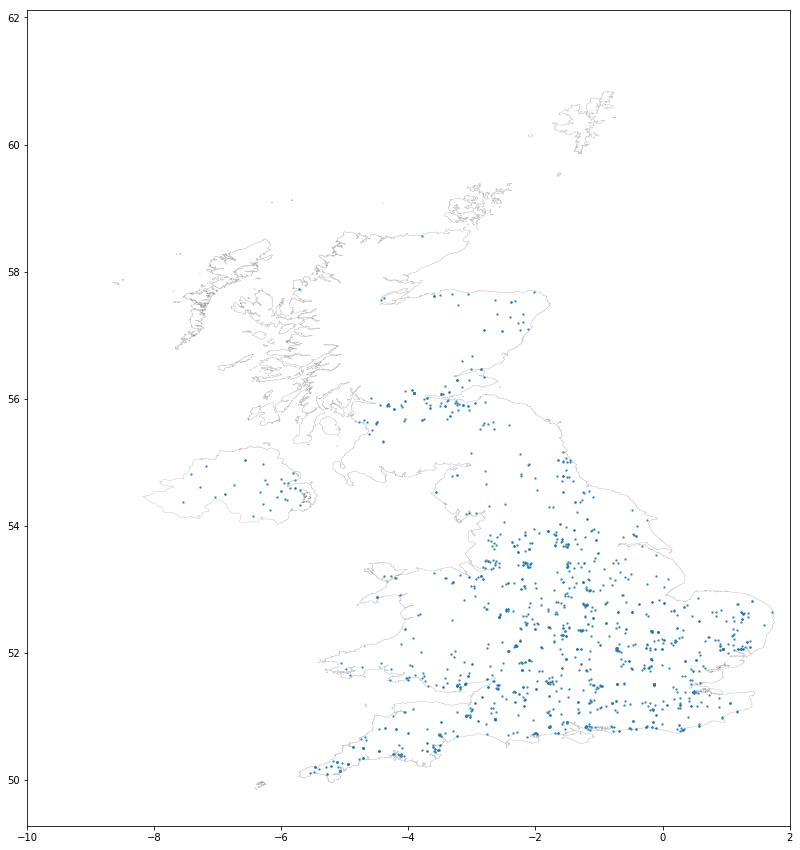

In [142]:
ax = country.plot(alpha=0.2, figsize=(15, 15), color='white', edgecolor='black', linewidth=0.5);
pv_system_gdf.query('num_outputs > 50').plot(ax=ax, alpha=0.7, markersize=2)
ax.set_xlim((-10, 2))

Next steps:
* De-dupe
* for any queries where we got 30 results, split that search area into smaller search areas and search again to get all pv systems.
* select systems with > ~100 readings
* pull metadata for these systems
* download timeseries for systems with 5-minutely data. Maybe get, say, June's data


In [150]:
num_results_per_query_grid_index = pv_systems.groupby('query_grid_index')['system_name'].count()

In [153]:
query_grid_indexes_to_revisit = num_results_per_query_grid_index[num_results_per_query_grid_index == 30].index

In [154]:
query_grid_indexes_to_revisit

Int64Index([ 10,  15,  22,  33,  43,  52,  55,  64,  73,  74,  75,  80,  86,
             87,  93,  94,  95,  96,  99, 100, 101, 102, 115, 116, 117, 118,
            119, 120, 121, 122, 123, 124, 133, 134, 135, 137, 138, 139, 140,
            141, 142, 143, 145, 146, 148, 149, 150, 151, 152, 153, 154, 155,
            156, 157, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173,
            174, 175, 176, 177, 178, 182, 183, 184, 185, 186, 189, 190, 191,
            192, 193, 195],
           dtype='int64', name='query_grid_index')